In [ ]:
# Copyright 2023 Gabriel Moreira
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Photo StoryTelling

What if we could use Generative AI to express with words what our photos represent, and have AI composing a storytelling about your moments? You could publish it online, share it with your dear ones, or keep that diary to yourself.

This notebook is accompanied by this [blog](https://gspmoreira.medium.com/photo-storytelling-leveraging-generative-ai-and-google-apis-to-compose-posts-from-your-photo-cce8e30f4d57). It demonstrates how you can use photos metadata (EXIF), and Google APIs for geolocation (Maps, Places) and Generative AI - Vertex Imagen for image captioning and Vertex Palm API for the post writing - when make the magic happens 😀.

<img src="https://raw.githubusercontent.com/gabrielspmoreira/photostorytelling_genai/cec7fb75ae57559d06e942857609d70e9770aa66/resources/images/photo_storytelling.png" />

This notebook was designed to work on Google Colab, as it provides easy integration and authentication to Google Cloud Platform APIs.

<div> <a href="https://colab.research.google.com/github/gabrielspmoreira/photostorytelling_genai/blob/main/PhotoStoryTelling.ipynb"><img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run on Colab</a>


<a href="https://github.com/gabrielspmoreira/photostorytelling_genai/blob/main/PhotoStoryTelling.ipynb"><img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">See at GitHub</a>
</div>

## Setup

This section contains just a few necessary setup instructions.

### Installs Google Cloud AI Platform client and authenticate
This notebook uses a number of Google APIs available in Vertex AI. It requires a Google Cloud Platform (GCP) project to be provided for execution.

Running this notebook on Google Colab is the easiest way to get autheticated to your GCP project.  
The next cell installs on Colab the Google Cloud AI Platform client for Python SDK. Then it authenticates with your Google Auth user (you need to accept and select your Google user) and restarts the kernel so that next cells work properly.



In [ ]:
import sys

if "google.colab" in sys.modules:
    ! pip3 install --upgrade google-cloud-aiplatform
    from google.colab import auth as google_auth

    google_auth.authenticate_user()

    # Restart the notebook kernel after installs.
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 16.8 MB/s eta 0:00:00


### Set up a GCP project
You can use an existing GCP account or create a new one [here](https://cloud.google.com/gcp) with USD 300 of free credits.
Please, set the name of the GCP project in the next cell.

In [ ]:
PROJECT_ID = "" # @param {type:"string"}

### Set up Google Maps APIs
#### Installs Google Maps SDK
This step installs [Google Maps SDK for Python](https://github.com/googlemaps/google-maps-services-python)

In [ ]:
!pip install -U googlemaps

  Preparing metadata (setup.py) ... done
  Created wheel for googlemaps: filename=googlemaps-4.10.0-py3-none-any.whl size=40711 sha256=e51e13fc005d6a43d65c812d27fbd4bd8264ed2ec3c86baedb54a24ad52bdec8
  Stored in directory: /root/.cache/pip/wheels/17/f8/79/999d5d37118fd35d7219ef57933eb9d09886c4c4503a800f84
Successfully built googlemaps


#### Get Google Maps Platform API key
This project uses Google Maps Platform APIs - in particular the Geocoding API and the Places API.
You need to get an Google Maps API key to be able to use them. For that go to the [Google Maps API project selector](https://console.cloud.google.com/projectselector2/google/maps-apis/credentials) and select your GCP project. An API key will be generated and provided in the following cell.  


In [ ]:
MAPS_API_KEY = "" # @param {type:"string"}

*Note*: If a popup message "Protect your API key" is display, you might apply some security mechanisms on top of it to avoid unauthorized usages of your API, you want might skip that step for the purpose of running this notebook and setup it later.
You might find mor information about [enabling Google Maps Platform](https://developers.google.com/maps/documentation/geocoding/cloud-setup) here if needed.


#### Enable required APIs
Enable the following APIs clicking on the links below or searching for them on [APIs & Services / Library](https://console.cloud.google.com/apis/library) of you GCP project:
- ["Geocoding API"](https://console.cloud.google.com/marketplace/product/google/geocoding-backend.googleapis.com)
- ["Places API"](https://console.cloud.google.com/marketplace/product/google/places-backend.googleapis.com)  

That is it. You are ready to use Google Maps APIs.



### Enable Vertex AI APIs

Go to this link and [enable Vertex AI APIs](https://console.cloud.google.com/apis/library/aiplatform.googleapis.com).

### Download example albuns
I have provided for this demo a few sampled photos from two trips I did to USA. The next cells will download and save them to `photos_la` and `photos_sf`.
The photos were taken from an iPhone and are in its raw format (HEIF extension).

- [Los Angeles trip](https://drive.google.com/file/d/1AqJawnzI3bP8jSh7EET20vJ4-ClZ76Ea/view?usp=drive_link)
- [San Francisco trip](https://drive.google.com/file/d/1_kNBMQIZ3RASfb60Tz1_8XZvLZU4Q2Q-/view?usp=sharing)

In [ ]:
!gdown https://drive.google.com/uc?id=1hid5rbtAt8kE_q2II-fG1gwFwNwcyeKD
!unzip la_trip.zip -d photos_la/

Downloading...
From: https://drive.google.com/uc?id=1hid5rbtAt8kE_q2II-fG1gwFwNwcyeKD
To: /content/la_trip.zip
100% 21.6M/21.6M [00:00<00:00, 50.0MB/s]
Archive:  la_trip.zip
  inflating: photos_la/IMG_2879.HEIC  
  inflating: photos_la/IMG_2889.HEIC  
  inflating: photos_la/IMG_2897.HEIC  
  inflating: photos_la/IMG_2906.HEIC  
  inflating: photos_la/IMG_2920.HEIC  
  inflating: photos_la/IMG_2943.HEIC  
  inflating: photos_la/IMG_2945.HEIC  
  inflating: photos_la/IMG_2956.HEIC  
  inflating: photos_la/IMG_2969.HEIC  
  inflating: photos_la/IMG_2973.HEIC  
  inflating: photos_la/IMG_2979.HEIC  
  inflating: photos_la/IMG_3039.HEIC  
  inflating: photos_la/IMG_3053.HEIC  
  inflating: photos_la/IMG_3057.HEIC  
  inflating: photos_la/IMG_3064.HEIC  


In [ ]:
!gdown https://drive.google.com/uc?id=1eoiF0TwVIBP0a72yZbdA2LckjildmAXj
!unzip sf_trip.zip -d photos_sf/

Downloading...
From: https://drive.google.com/uc?id=1eoiF0TwVIBP0a72yZbdA2LckjildmAXj
To: /content/sf_trip.zip
100% 21.2M/21.2M [00:00<00:00, 138MB/s]
Archive:  sf_trip.zip
  inflating: photos_sf/IMG_4371.heic  
  inflating: photos_sf/IMG_4378.heic  
  inflating: photos_sf/IMG_4390.heic  
  inflating: photos_sf/IMG_4504.jpg  
  inflating: photos_sf/IMG_4530.heic  
  inflating: photos_sf/IMG_4600.heic  
  inflating: photos_sf/IMG_4617.heic  
  inflating: photos_sf/IMG_4627.jpg  
  inflating: photos_sf/IMG_4677.heic  
  inflating: photos_sf/IMG_4682.heic  
  inflating: photos_sf/IMG_4690.heic  
  inflating: photos_sf/IMG_4691.heic  


In [ ]:
https://drive.google.com/file/d/1eoiF0TwVIBP0a72yZbdA2LckjildmAXj/view?usp=drive_link

### Uploading your own photos (optional)

If you want to give this notebook a try with your own photos, you need to choose the "Files" menu on the left of Colab, right click in an empty space and choose "New folder" and upload your photos to that folder.   
You can also click in "Mount Drive" to connect Colab to you Google Drive and copy your photos from there.

#### Information about supported photos format
This notebook supports digital photos in their raw format, for example taken by
iPhone (HEIF format) or Android (JPEG format). That is important because raw photos typically include metadata (EXIF) that stores the location (latitude/longitude) and capture date/time, and we'll use that information as context for the generation of the album post.  
*Note*: You might check the metadata of the images by right-clicking the files on your operational system (e.g. Windows, Mac, Linux) and inspecting the file properties.

## Processing photos

Select the folder with raw photos

In [ ]:
RAW_PHOTOS_PATH = "photos_la/" # @param {type:"string"}

### Loading and converting images
We need to load the photos within the selected folder and do some preprocessing, for which we use [Pillow](https://pillow.readthedocs.io/en/stable/) imaging library:
- Extract metadata (EXIF)
- Resize to smaller size (max dimension (width or height) of 800 pixels
- Convert to JPG (as HEIF format for example is not supported by the APIs)
- Save the converted photos to a `photos_converted` subfolder

In [ ]:
CONVERTED_PATH = os.path.join(RAW_PHOTOS_PATH, "photos_converted")

In [ ]:
import PIL
from PIL.ExifTags import IFD, GPSTAGS, TAGS

In [ ]:
# Adds support of HEIF image format (for Apple mobile devices) to Pillow
!pip install pillow_heif
from pillow_heif import register_heif_opener
register_heif_opener()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 15.0 MB/s eta 0:00:00


In [ ]:
import os
from tqdm import tqdm
from pprint import pprint

In [ ]:
def get_exif_properties(img):
    exif = img.getexif()

    properties = dict()
    for k, v in exif.items():
        tag = TAGS.get(k, k)
        properties[tag] = v

    for ifd_id in IFD:
        try:
            ifd = exif.get_ifd(ifd_id)

            if ifd_id == IFD.GPSInfo:
                resolve = GPSTAGS
            else:
                resolve = TAGS

            for k, v in ifd.items():
                tag = resolve.get(k, k)
                properties[tag] = v
        except KeyError:
            pass

    return properties

In [ ]:
def convert_images_extract_exif(raw_images_path, converted_images_path, max_width_height=800):
    """ Converting images to JPEG and extracting EXIF properties """

    os.makedirs(converted_images_path, exist_ok=True)

    image_paths_exif = dict()
    for entry in os.scandir(raw_images_path):
        if entry.is_dir():
            # skip directories
            continue

        new_fname = ".".join(entry.name.split(".")[:-1]) + ".jpg"
        new_fpath = os.path.join(converted_images_path, new_fname)
        print(f"Converting {entry.path} to {new_fpath}")
        # Loading image
        image = PIL.Image.open(entry.path)
        # Downsizing
        image.thumbnail((max_width_height, max_width_height))
        # Saving as a new JPEG file, keeping the EXIF poperties from original image
        image.save(new_fpath, exif=image.info["exif"])
        # Extracting EXIF properties as a dict
        image_paths_exif[new_fpath] = get_exif_properties(image)
    return image_paths_exif

In [ ]:
image_paths_exif = convert_images_extract_exif(RAW_PHOTOS_PATH, CONVERTED_PATH)

Converting photos_la/IMG_2889.HEIC to photos_la/photos_converted/IMG_2889.jpg
Converting photos_la/IMG_2906.HEIC to photos_la/photos_converted/IMG_2906.jpg
Converting photos_la/IMG_2979.HEIC to photos_la/photos_converted/IMG_2979.jpg
Converting photos_la/IMG_3039.HEIC to photos_la/photos_converted/IMG_3039.jpg
Converting photos_la/IMG_2943.HEIC to photos_la/photos_converted/IMG_2943.jpg
Converting photos_la/IMG_2920.HEIC to photos_la/photos_converted/IMG_2920.jpg
Converting photos_la/IMG_2956.HEIC to photos_la/photos_converted/IMG_2956.jpg
Converting photos_la/IMG_3053.HEIC to photos_la/photos_converted/IMG_3053.jpg
Converting photos_la/IMG_2973.HEIC to photos_la/photos_converted/IMG_2973.jpg
Converting photos_la/IMG_2879.HEIC to photos_la/photos_converted/IMG_2879.jpg
Converting photos_la/IMG_3057.HEIC to photos_la/photos_converted/IMG_3057.jpg
Converting photos_la/IMG_2969.HEIC to photos_la/photos_converted/IMG_2969.jpg
Converting photos_la/IMG_2945.HEIC to photos_la/photos_converted

### Extracting information from EXIF properties

Here is the example of the EXIF properties of the first image

In [ ]:
image_paths_exif[list(image_paths_exif.keys())[0]]

{'TileWidth': 512,
 'TileLength': 512,
 'GPSInfo': 2356,
 'ResolutionUnit': 2,
 'ExifOffset': 248,
 'Make': 'Apple',
 'Model': 'iPhone 14 Pro',
 'Software': '16.5.1',
 'Orientation': 6,
 'DateTime': '2023:08:04 09:32:46',
 'XResolution': 72.0,
 'YResolution': 72.0,
 'HostComputer': 'iPhone 14 Pro',
 'ExifVersion': b'0232',
 'ShutterSpeedValue': 12.086078519855596,
 'ApertureValue': 1.663754482562451,
 'DateTimeOriginal': '2023:08:04 09:32:46',
 'DateTimeDigitized': '2023:08:04 09:32:46',
 'BrightnessValue': 9.63871012870733,
 'ExposureBiasValue': 0.0,
 'MeteringMode': 5,
 'ColorSpace': 1,
 'Flash': 16,
 'FocalLength': 6.86,
 'ExifImageWidth': 836,
 'ExifImageHeight': 627,
 'FocalLengthIn35mmFilm': 24,
 'OffsetTime': '-07:00',
 'OffsetTimeOriginal': '-07:00',
 'OffsetTimeDigitized': '-07:00',
 'SubsecTimeOriginal': '568',
 'SubjectLocation': (1294, 1425, 181, 184),
 'SubsecTimeDigitized': '568',
 'SensingMethod': 2,
 'ExposureTime': 0.00022999080036798528,
 'FNumber': 1.78,
 'SceneType'

### Extracting date-time and location from EXIF properties
In this section we extract the information we need from the photos, the coordinates (latitude, longitude) and the date/time when the picture was taken.

In [ ]:
def decimal_coords(coords, ref):
    decimal_degrees = float(coords[0]) + float(coords[1]) / 60 + float(coords[2]) / 3600
    if ref == "S" or ref == "W":
        decimal_degrees = -decimal_degrees
    return decimal_degrees

In [ ]:
def extract_useful_exif(properties):
    out_props = dict()
    out_props["datetime"] = properties['DateTimeOriginal']
    out_props["latitude"] = decimal_coords(properties['GPSLatitude'], properties['GPSLatitudeRef'])
    out_props["longitude"] = decimal_coords(properties['GPSLongitude'], properties['GPSLongitudeRef'])
    return out_props

In [ ]:
images_info = [{**{"path": k}, **extract_useful_exif(v)} for k,v in image_paths_exif.items()]
images_info

[{'path': 'photos_la/photos_converted/IMG_2889.jpg',
  'datetime': '2023:08:04 09:32:46',
  'latitude': 33.951997222222225,
  'longitude': -118.39020555555557},
 {'path': 'photos_la/photos_converted/IMG_2906.jpg',
  'datetime': '2023:08:04 10:29:36',
  'latitude': 33.97989722222223,
  'longitude': -118.46936666666667},
 {'path': 'photos_la/photos_converted/IMG_2979.jpg',
  'datetime': '2023:08:04 13:15:35',
  'latitude': 34.01374722222222,
  'longitude': -118.49397222222223},
 {'path': 'photos_la/photos_converted/IMG_3039.jpg',
  'datetime': '2023:08:04 17:03:13',
  'latitude': 34.07188333333334,
  'longitude': -118.35683333333333},
 {'path': 'photos_la/photos_converted/IMG_2943.jpg',
  'datetime': '2023:08:04 11:43:19',
  'latitude': 34.00818611111111,
  'longitude': -118.49900833333334},
 {'path': 'photos_la/photos_converted/IMG_2920.jpg',
  'datetime': '2023:08:04 11:29:43',
  'latitude': 34.00963333333333,
  'longitude': -118.4971861111111},
 {'path': 'photos_la/photos_converted/IM

## Extracting location and nearby places using Google Maps APIs
Here we use extracted georeferenced information from the photo coordinates with Google Maps:
- Reverse Geocoding - Returns the potential known location from a geographic coordinate.
- Nearby Places - Returns known places (e.g. landmarks, buildings, restaurants) nearby the coordinate.

In [ ]:
import googlemaps
from datetime import datetime
gmaps = googlemaps.Client(key=MAPS_API_KEY)

In [ ]:
# Reverse Geocoding (Geocoding API)
def get_locations(lat, lng, topk=5):
    """Reverse geocoding to get the photo locations"""
    results = gmaps.reverse_geocode(latlng=(lat,lng), result_type=None, location_type=None, language=None)

    locations = []
    for result in results:
        address_component = result['address_components'][0]
        address_types = address_component['types']
        if len(set(['street_number', 'route', 'plus_code', 'postal_code',
                    'premise', 'subpremise']).intersection(set(address_types))) > 0:
            # Ignoring these types of addresses
            continue
        name = address_component['long_name']
        locations.append(name)
    return locations[:topk]

In [ ]:
# Places Nearby (Places API)
def get_nearby_locations(lat, lng, radius=100, topk=5):
    """Finds nearby locations to the place the photo was taken"""
    results = gmaps.places_nearby(location=(lat,lng), radius=radius, language=None, name=None)
    locations = [r["name"] for r in results["results"]
                 # Ignores some types of locations
                 if len(set(['street_number', 'route', 'plus_code', 'postal_code',
                             'premise', 'subpremise']).intersection(set(r["types"]))) == 0]
    return locations[:topk]

In [ ]:
# Getting location and nearby locations from the photo coordinate
for v in tqdm(images_info):
    v["locations"] = get_locations(v["latitude"], v["longitude"])
    v["nearby_locations"] = get_nearby_locations(v["latitude"], v["longitude"], radius=50)

100%|██████████| 15/15 [00:02<00:00,  6.75it/s]


In [ ]:
# Sorting images by date/time and assigning them contiguous ids
images_info = sorted(images_info, key=lambda x: x["datetime"])
for idx, v in enumerate(images_info):
    v["image_id"] = idx

Here we can check the `"locations"` and `"nearby_locations"` inferred by Google Maps from the photo cooordinate.

In [ ]:
images_info

[{'path': 'photos_la/photos_converted/IMG_2879.jpg',
  'datetime': '2023:08:04 07:53:13',
  'latitude': 33.94403888888888,
  'longitude': -118.41053055555557,
  'locations': ['BURBERRY LAX TERMINAL B',
   'Los Angeles International Airport',
   'Los Angeles',
   'Los Angeles County',
   'California'],
  'nearby_locations': ['Los Angeles',
   'Star Alliance Lounge',
   'ICE International Currency Exchange',
   'Relay',
   'Bank of America'],
  'image_id': 0},
 {'path': 'photos_la/photos_converted/IMG_2889.jpg',
  'datetime': '2023:08:04 09:32:46',
  'latitude': 33.951997222222225,
  'longitude': -118.39020555555557,
  'locations': ['Los Angeles International Airport',
   'Los Angeles',
   'Los Angeles County',
   'California',
   'United States'],
  'nearby_locations': ['Los Angeles'],
  'image_id': 1},
 {'path': 'photos_la/photos_converted/IMG_2897.jpg',
  'datetime': '2023:08:04 09:59:07',
  'latitude': 33.95962777777778,
  'longitude': -118.41903055555557,
  'locations': ['Westcheste

## Photo captioning using Generative AI with Vertex Imagen
In this section we start using Generative AI. Vertex Imagen provides an API for image captioning, i.e., describing in text what is in the picture.

In [ ]:
import vertexai
from vertexai.vision_models import ImageTextModel, Image

vertexai.init(project=PROJECT_ID)
model = ImageTextModel.from_pretrained("imagetext")

In [ ]:
def image_captioning(path):
    source_image = Image.load_from_file(location=path)

    captions = model.get_captions(
        image=source_image,
        number_of_results=1,
        language="en",
    )
    return captions

In [ ]:
for v in tqdm(images_info):
    v["caption"] = image_captioning(v["path"])

100%|██████████| 15/15 [00:32<00:00,  2.19s/it]


We can check here that photo information was enriched by the a "magically" generated `"caption"`.

In [ ]:
images_info

[{'path': 'photos_la/photos_converted/IMG_2879.jpg',
  'datetime': '2023:08:04 07:53:13',
  'latitude': 33.94403888888888,
  'longitude': -118.41053055555557,
  'locations': ['BURBERRY LAX TERMINAL B',
   'Los Angeles International Airport',
   'Los Angeles',
   'Los Angeles County',
   'California'],
  'nearby_locations': ['Los Angeles',
   'Star Alliance Lounge',
   'ICE International Currency Exchange',
   'Relay',
   'Bank of America'],
  'image_id': 0,
  'caption': ['a man stands in front of a sign that says welcome to the united states']},
 {'path': 'photos_la/photos_converted/IMG_2889.jpg',
  'datetime': '2023:08:04 09:32:46',
  'latitude': 33.951997222222225,
  'longitude': -118.39020555555557,
  'locations': ['Los Angeles International Airport',
   'Los Angeles',
   'Los Angeles County',
   'California',
   'United States'],
  'nearby_locations': ['Los Angeles'],
  'image_id': 1,
  'caption': ['a man in a nasa shirt is sitting in a white car']},
 {'path': 'photos_la/photos_con

## Designing the prompt
It is time to create the *prompt* that will be responsible to instruct a Large Language Model (LLM) to generate the post about photos.  
The *prompt* needs to provide instructions and constraints on the desired outputs and include the relevant metadata we captured from the photos.

#### Serializing the relevant metadata from the photos

In [ ]:
import dateutil

In [ ]:
def combine_photo_info(image_id, image_info):
    date, tm = image_info['datetime'].split(" ")
    date = date.replace(":", "/")
    datetm = dateutil.parser.parse(f"{date} {tm}").strftime("%m/%d/%Y (%A) %I:%M %p")

    return f"- <Photo {image_id}> | Date and time: {datetm} | Photo Description: {image_info['caption'][0]} | " \
           f"Locations: {', '.join(image_info['locations'][:5])} | Possible Nearby locations: {', '.join(image_info['nearby_locations'][:5])} \n"

In [ ]:
import textwrap

In [ ]:
def print_wrapped(text, width=90):
    lines = text.split('\n')
    wrapped_lines = [textwrap.wrap(line, width=width) for line in lines]
    wrapped_lines = [y for x in wrapped_lines for y in x]
    print('\n'.join(wrapped_lines))

In [ ]:
def combine_photos_info(images_info):
    photos_info_concat = ""
    for i in range(len(images_info)):
        photos_info_concat += combine_photo_info(i, images_info[i]) + "\n"
    return photos_info_concat

In [ ]:
photos_info_concat = combine_photos_info(images_info)
print_wrapped(photos_info_concat)

- <Photo 0> | Date and time: 08/04/2023 (Friday) 07:53 AM | Photo Description: a man
stands in front of a sign that says welcome to the united states | Locations: BURBERRY LAX
TERMINAL B, Los Angeles International Airport, Los Angeles, Los Angeles County, California
| Possible Nearby locations: Los Angeles, Star Alliance Lounge, ICE International Currency
Exchange, Relay, Bank of America
- <Photo 1> | Date and time: 08/04/2023 (Friday) 09:32 AM | Photo Description: a man in a
nasa shirt is sitting in a white car | Locations: Los Angeles International Airport, Los
Angeles, Los Angeles County, California, United States | Possible Nearby locations: Los
Angeles
- <Photo 2> | Date and time: 08/04/2023 (Friday) 09:59 AM | Photo Description: a man in a
white shirt is driving a mustang | Locations: Westchester, Los Angeles, Los Angeles
County, California, United States | Possible Nearby locations: Plaza Towers OBGYN:
Lawrence Bruksch, MD, LA Fitness, Dr. Jitsen Chang, Obstetrician-gynecologist

#### Prompt engineering

The following function encapsulates the *prompt* to the LLM, which I have curated over a bunch of trial-an-error to maximize the chance the get the output post in the desired shape.   

You can notice that I added a bunch of human-like instructions to provide the LLM information about the desired personality for the writing, about the input photos description format and included constraints on the desired output (e.g. referencing the \<Photo id\> when describing a photo).

This *prompt* utilizes a technique called *few-shot prompting*, in which we provide an example of the serialized metadata from a photo and the expected output. Using *few-shot prompting* here was not a requirement here from my tests, but it is general a good practice for LLM prompt engineering, so I keep it here.

In [ ]:
def generate_prompt(context, pictures_infos):
    prompt = f"""
          You are a copywriter and journalist.
          Can you help me write a photo tour that describes the moments registered in a photo album
          from a context and some information I provide about the photos?

          The items were already sorted by the date and time the photos were taken.
          Pay attention to the dates and time to infer how many days were
          covered by these photos and at which time of the day they were taken.

          Please include descriptions of all the photos taken.
          Only report places or experiences that are described by the
          photo informations.

          The photos information has the following structure:

          - <Photo id> | Date the photo was taken | Time the photo was taken |
            Photo Description generated by an LLM  |
            Approximate Locations where the photo was taken |
            Approximate Nearby locations where photo was taken

          Here is an example of photo information and how it should be generated in plain text,
          interleaving photo descriptions and the <Photo id>.


          Example photo information:
          - <Photo 0> | Date: 08/04/2023 | Time: 07:53:13 |
          Photo Description: a man stands in front of a sign that says welcome to the united states |
          Possible Photo Locations: BURBERRY LAX TERMINAL B, Los Angeles International Airport, Terminal B, Los Angeles, Los Angeles County |
          Possible Photo Nearby locations: Los Angeles, Star Alliance Lounge, ICE International Currency Exchange, Relay, Bank of America

          Expected output:
          I was happy finally arriving to my destination, Los Angeles.
          While I went into US Customs my heart was filled of anxiety to leave the airport
          and get to visit the city.
          <Photo 0>

          ```
          Photos album context: {context}

          Photos description:
          {pictures_infos}
          ```
          """
    return prompt

Notice the *prompt* includes a placeholder for the photos description and for a context paragraph that you might want to include to improve the generated post.   
Here I provide a short context about my trip to LA and generate the *prompt* including the photos information.  

In [ ]:
album_context = "I flew to Los Angeles for a short trip, and the album contains the photos " \
                "from the day I arrived there. The man in those photos is myself."

blog_prompt = generate_prompt(album_context, photos_info_concat)
print_wrapped(blog_prompt)

          You are a copywriter and journalist.
          Can you help me to write a photo tour that describes the moments registered in a
photo album
          from a context and some information I provide about the photos?
          The items are already sorted by the time the photos was taken.
          Pay attention to the dates and time to infer how many days were
          covered by these photos and in which time of the day they were taken.
          Please include descriptions of all the photos taken.
          Do not report any place or experience that is not described by the
          photo informations.
          The photos information has following structure:
          - <Photo id> | Date the photo was taken | Time the photo was taken |
            Photo Description generated by an LLM  |
            Approximate Locations where the photo was taken |
            Approximate Nearby locations where photo was taken
          Here is an example of photo information and how it sho

You can copy-and-past this generated prompt to any user-facing LLM chat system, like [BARD](https://bard.google.com/) or [Chat-GPT](https://chat.openai.com/) and probably get impressed with the result.   

Here we will use the Vertex AI Palm API to generate a post with text interleaved with the photos.

## Generating post about my trip to Los Angeles

We use the [TextGenerationModel](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/text) from Vertex Palm API for single message requests. It supports some configuration of the level of randomness/creativeness by setting the *temperature*, *top_k* and top_p, as explained in the comments and on the [API docs](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/text).

In [ ]:
from vertexai.language_models import TextGenerationModel
generation_model = TextGenerationModel.from_pretrained("text-bison@001")

In [ ]:
def generate_text(prompt, temperature=1.0, top_p= 0.4, top_k=40, max_output_tokens=1024):
    parameters = {
        "temperature": temperature,  # Temperature controls the degree of randomness in token selection.
        "max_output_tokens": max_output_tokens,  # Token limit determines the maximum amount of text output.
        "top_p": top_p,  # Tokens are selected from most probable to least until the sum of their probabilities equals the top_p value.
        "top_k": top_k,  # A top_k of 1 means the selected token is the most probable among all tokens.
    }

    generated_text = generation_model.predict(prompt=prompt, **parameters).text
    return generated_text

Then we finally generate the post from our photo album. As the LLM generative models outputs are non-deterministic, I generate different versions of the post so that you can compare.

#### Post #1

In [ ]:
generated_post_1 = generate_text(prompt=blog_prompt)
print(generated_post_1)

I was happy finally arriving to my destination, Los Angeles.
          While I went into US Customs my heart was filled of anxiety to leave the airport
          and get to visit the city.
          <Photo 0>

          I took a taxi to my hotel in Eagle Rock.
          The room was small but cozy.
          <Photo 14>

          The next morning I went for a walk around the neighborhood.
          It was a beautiful day and the sun was shining brightly.
          <Photo 11>

          I stopped at a coffee shop for breakfast.
          The coffee was delicious and the service was excellent.
          <Photo 12>

          After breakfast I went to the Farmers Market.
          There were so many different stalls to choose from.
          I bought some fresh fruit, vegetables, and flowers.
          <Photo 13>

          I spent the rest of the day exploring the city.
          I visited the Santa Monica Pier and saw the Ferris wheel.
          I also had lunch at the Cheesecake Factor

#### Post #2

In [ ]:
generated_post_2 = generate_text(prompt=blog_prompt)
print(generated_post_2)

I arrived in Los Angeles on Friday morning, and I was excited to explore the city.

          <Photo 0>

          I first went to the BURBERRY LAX TERMINAL B to pick up my luggage.

          <Photo 1>

          Then I got in my rental car and drove to my hotel in Eagle Rock.

          <Photo 2>

          After I checked in, I went for a walk around the neighborhood.

          <Photo 3>

          I found a nice beach and spent some time relaxing in the sun.

          <Photo 4>

          I then went to Santa Monica Pier and had lunch at Bubba Gump Shrimp Co.

          <Photo 5>

          After lunch, I walked around the pier and took some pictures of the Ferris wheel.

          <Photo 6>

          I also saw a seagull sitting on the railing.

          <Photo 7>

          I then went to the Cheesecake Factory for dinner.

          <Photo 8>

          I ordered a steak and lobster, and it was delicious.

          <Photo 9>

          I also got a slice of cheesecake for d

#### Post #3

In [ ]:
generated_post_3 = generate_text(prompt=blog_prompt, temperature=0.5, top_p= 0.4, top_k=40)
print(generated_post_3)

I was happy finally arriving to my destination, Los Angeles.
          While I went into US Customs my heart was filled of anxiety to leave the airport
          and get to visit the city.
          <Photo 0>

          I rented a car and drove to my hotel in Eagle Rock.
          The hotel was nice and comfortable.
          <Photo 14>

          The next morning I went to Santa Monica Pier.
          I had lunch at Bubba Gump Shrimp Co. and then walked around the pier.
          <Photo 4>, <Photo 5>, <Photo 6>, <Photo 7>

          In the afternoon I went to the Cheesecake Factory.
          I had a delicious meal and then went shopping at the mall.
          <Photo 8>, <Photo 9>, <Photo 10>

          In the evening I went to Farmers Market.
          I bought some caramel apples and ice cream.
          <Photo 11>, <Photo 12>, <Photo 13>

          It was a long day but I had a lot of fun.
          I can't wait to explore more of Los Angeles tomorrow.


#### Post #4

In [ ]:
generated_post_4 = generate_text(prompt=blog_prompt, temperature=0.6)
print(generated_post_4)

I was happy finally arriving to my destination, Los Angeles.
          While I went into US Customs my heart was filled of anxiety to leave the airport
          and get to visit the city.
          <Photo 0>

          I took a taxi to my hotel in Eagle Rock.
          The room was small but cozy.
          <Photo 14>

          After dropping off my bags, I went out to explore the city.
          I first drove to Santa Monica Pier.
          I walked along the pier and took in the sights and sounds of the ocean.
          I even rode the Ferris wheel!
          <Photo 4>, <Photo 5>, <Photo 6>, <Photo 7>

          After spending some time at the pier, I went to the Cheesecake Factory for lunch.
          The food was delicious and the service was excellent.
          <Photo 8>, <Photo 9>

          In the afternoon, I went to the Farmers Market in La Brea.
          I bought some fresh produce and flowers.
          I also had some ice cream.
          <Photo 11>, <Photo 12>, <Photo 

Let's display one of those generated posts with the actual pictures, as that is what we are looking forward to post.

In [ ]:
import re
from matplotlib import pyplot as plt
import cv2

In [ ]:
def display_image(path):
    img_color = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    plt.imshow(img_color)
    plt.axis("off")
    plt.show()

def print_post_with_photos(gen_post, images_info):
    paragraphs = gen_post.split("\n")
    for p in paragraphs:
        image_ids = re.findall("<Photo\s(\d+)>", p)
        if image_ids:
            p = re.sub("<Photo\s\d+>,*", "", p)
            print_wrapped(p.strip())
            for im_id in image_ids:
                im_id = int(im_id)
                if im_id < len(images_info):
                    path = images_info[im_id]["path"]
                    display_image(path)
        else:
            print_wrapped(p.strip())

I was happy finally arriving to my destination, Los Angeles.
While I went into US Customs my heart was filled of anxiety to leave the airport
and get to visit the city.



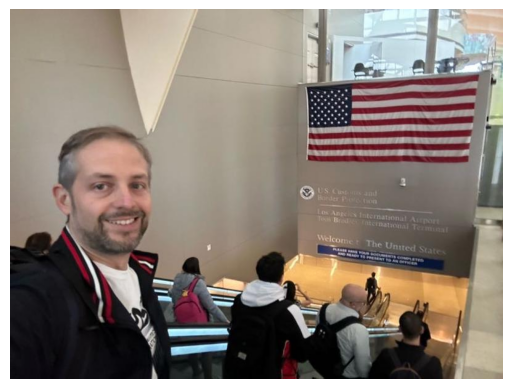


I took a taxi to my hotel in Eagle Rock.
The room was small but cozy.



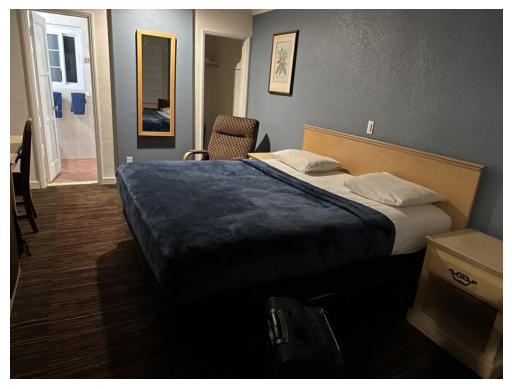


After dropping off my bags, I went out to explore the city.
I first drove to Santa Monica Pier.
I walked along the pier and took in the sights and sounds of the ocean.
I even rode the Ferris wheel!



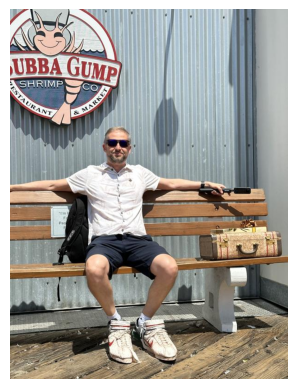

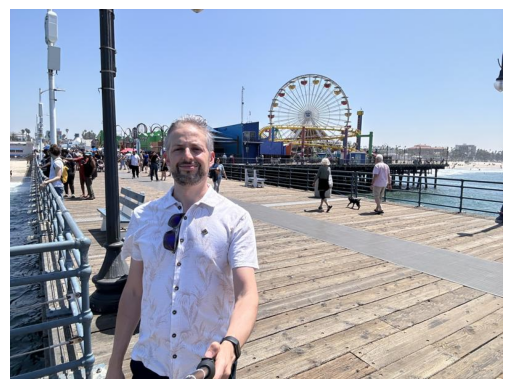

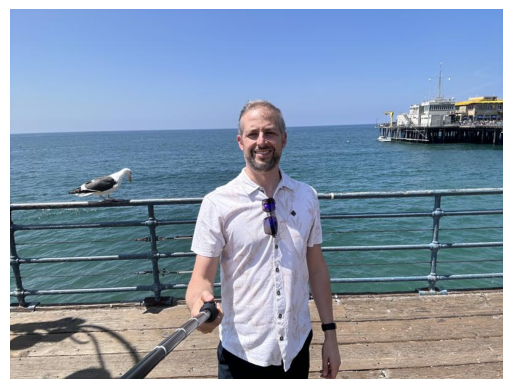

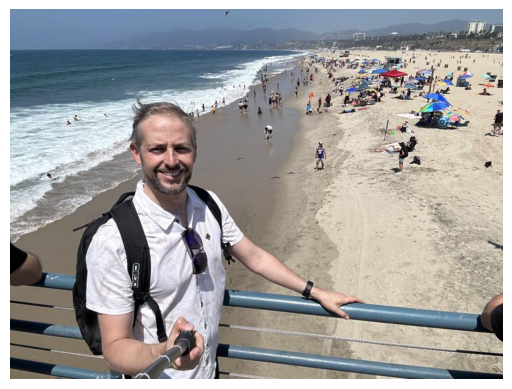


After spending some time at the pier, I went to the Cheesecake Factory for lunch.
The food was delicious and the service was excellent.



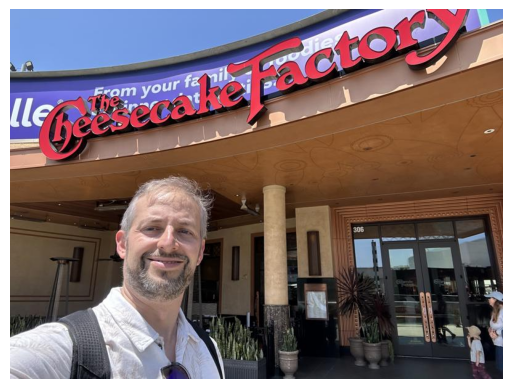

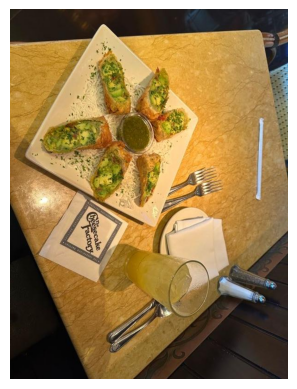


In the afternoon, I went to the Farmers Market in La Brea.
I bought some fresh produce and flowers.
I also had some ice cream.



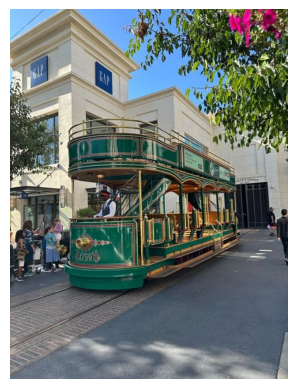

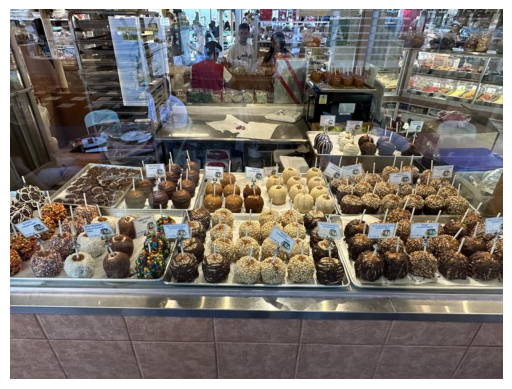

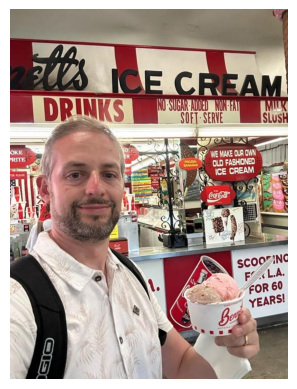


I ended my day by going back to my hotel room and relaxing.
I was tired from all the exploring I had done, but I was also excited to see what the next
day would bring.


In [ ]:
print_post_with_photos(generated_post_4, images_info)

How this post looks like for you!
I would certainly not automating publishing a post using Generative AI, but it can definitelly help to build a good draft!

## Generating post about my San Francisco trip

Let's see another example, for my trip to San Francisco, this time with my wife. So hope the blog post gets perfect now!

#### Processing images

In [ ]:
RAW_PHOTOS_PATH = "photos_sf/"
CONVERTED_PATH = os.path.join(RAW_PHOTOS_PATH, "photos_converted")
image_paths_exif_sf = convert_images_extract_exif(RAW_PHOTOS_PATH, CONVERTED_PATH)

Converting photos_sf/IMG_4627.jpg to photos_sf/photos_converted/IMG_4627.jpg
Converting photos_sf/IMG_4691.heic to photos_sf/photos_converted/IMG_4691.jpg
Converting photos_sf/IMG_4390.heic to photos_sf/photos_converted/IMG_4390.jpg
Converting photos_sf/IMG_4682.heic to photos_sf/photos_converted/IMG_4682.jpg
Converting photos_sf/IMG_4677.heic to photos_sf/photos_converted/IMG_4677.jpg
Converting photos_sf/IMG_4371.heic to photos_sf/photos_converted/IMG_4371.jpg
Converting photos_sf/IMG_4504.jpg to photos_sf/photos_converted/IMG_4504.jpg
Converting photos_sf/IMG_4690.heic to photos_sf/photos_converted/IMG_4690.jpg
Converting photos_sf/IMG_4530.heic to photos_sf/photos_converted/IMG_4530.jpg
Converting photos_sf/IMG_4600.heic to photos_sf/photos_converted/IMG_4600.jpg
Converting photos_sf/IMG_4617.heic to photos_sf/photos_converted/IMG_4617.jpg
Converting photos_sf/IMG_4378.heic to photos_sf/photos_converted/IMG_4378.jpg


#### Extracting useful EXIF info

In [ ]:
images_info_sf = [{**{"path": k}, **extract_useful_exif(v)} for k,v in image_paths_exif_sf.items()]
images_info_sf

[{'path': 'photos_sf/photos_converted/IMG_4627.jpg',
  'datetime': '2023:09:17 18:40:01',
  'latitude': 37.80193333333333,
  'longitude': -122.44799166666667},
 {'path': 'photos_sf/photos_converted/IMG_4691.jpg',
  'datetime': '2023:09:17 20:43:31',
  'latitude': 37.80580277777778,
  'longitude': -122.42226388888889},
 {'path': 'photos_sf/photos_converted/IMG_4390.jpg',
  'datetime': '2023:09:17 15:21:12',
  'latitude': 37.820594444444446,
  'longitude': -122.52966388888889},
 {'path': 'photos_sf/photos_converted/IMG_4682.jpg',
  'datetime': '2023:09:17 20:09:44',
  'latitude': 37.810227777777776,
  'longitude': -122.41043888888889},
 {'path': 'photos_sf/photos_converted/IMG_4677.jpg',
  'datetime': '2023:09:17 19:43:52',
  'latitude': 37.80894444444444,
  'longitude': -122.40973611111112},
 {'path': 'photos_sf/photos_converted/IMG_4371.jpg',
  'datetime': '2023:09:17 12:32:30',
  'latitude': 37.61597777777778,
  'longitude': -122.38342222222222},
 {'path': 'photos_sf/photos_converted/

#### Getting location and nearby locations from the photo coordinate and image captioning

In [ ]:
for v in tqdm(images_info_sf):
    v["locations"] = get_locations(v["latitude"], v["longitude"])
    v["nearby_locations"] = get_nearby_locations(v["latitude"], v["longitude"], radius=50)
    v["caption"] = image_captioning(v["path"])

100%|██████████| 12/12 [00:47<00:00,  3.93s/it]


In [ ]:
# Sorting images by date/time and assigning them contiguous ids
images_info_sf = sorted(images_info_sf, key=lambda x: x["datetime"])
for idx, v in enumerate(images_info_sf):
    v["image_id"] = idx

In [ ]:
photos_info_concat_sf = combine_photos_info(images_info_sf)
print_wrapped(photos_info_concat_sf)

- <Photo 0> | Date and time: 09/17/2023 (Sunday) 12:32 PM | Photo Description: a man and
woman standing in front of a delta airplane | Locations: Terminal 2 Lower Level Bus Stop,
San Francisco International Airport, San Mateo County, California, United States |
Possible Nearby locations: SFO Airport Control Tower
- <Photo 1> | Date and time: 09/17/2023 (Sunday) 01:45 PM | Photo Description: a stop sign
is in the middle of a busy street | Locations: Fay Park, Russian Hill, San Francisco, San
Francisco County, California | Possible Nearby locations: Jamey Thomas Photography, Fay
Park, 2355 Leavenworth Apartments, San Francisco
- <Photo 2> | Date and time: 09/17/2023 (Sunday) 03:21 PM | Photo Description: a man and
woman are posing for a picture with the golden gate bridge in the background | Locations:
Marin County, California, United States | Possible Nearby locations:
- <Photo 3> | Date and time: 09/17/2023 (Sunday) 04:33 PM | Photo Description: a man and a
woman are sitting on a bench

#### Generating the prompt

In [ ]:
album_context_sf = "Me and my wife traveled to San Francisco. " \
          "We spent a single day there. We rented a car in SF and visited "\
          "many places during that day. " \
          "The man in the pictures is myself and the woman is my wife."
blog_prompt_sf = generate_prompt(album_context_sf, photos_info_concat_sf)
print_wrapped(blog_prompt_sf)

          You are a copywriter and journalist.
          Can you help me to write a photo tour that describes the moments registered in a
photo album
          from a context and some information I provide about the photos?
          The items are already sorted by the time the photos was taken.
          Pay attention to the dates and time to infer how many days were
          covered by these photos and in which time of the day they were taken.
          Please include descriptions of all the photos taken.
          Do not report any place or experience that is not described by the
          photo informations.
          The photos information has following structure:
          - <Photo id> | Date the photo was taken | Time the photo was taken |
            Photo Description generated by an LLM  |
            Approximate Locations where the photo was taken |
            Approximate Nearby locations where photo was taken
          Here is an example of photo information and how it sho

### Generating posts about my SF trip
Let's generate a few examples of blog posts from my San Francisco pictures.

In [ ]:
generated_post_1_sf = generate_text(prompt=blog_prompt_sf)
print(generated_post_1_sf)

Me and my wife travelled to San Francisco. We spent a single day there. We rented a car in SF visited many places during that day. The man in the pictures is myself and the woman is my wife.

<Photo 0>
We started our day at the San Francisco International Airport. We were excited to finally be in San Francisco and ready to explore the city.

<Photo 1>
We drove to Russian Hill and found a parking spot. We walked around the neighborhood and took in the sights and sounds.

<Photo 2>
We walked over to the Golden Gate Bridge and took some pictures. It was a beautiful day and the bridge was stunning.

<Photo 3>
We sat on a bench and watched the boats go by. It was so peaceful and relaxing.

<Photo 4>
We walked back to our car and drove to the Marina District. We walked around the lake and enjoyed the scenery.

<Photo 5>
We stopped for dinner at a restaurant in the Marina District. The food was delicious and the atmosphere was lively.

<Photo 6>
We walked around the Marina District after dinn

In [ ]:
generated_post_2_sf = generate_text(prompt=blog_prompt_sf)
print(generated_post_2_sf)

Me and my wife travelled to San Francisco. We spent a single day there. We rented a car in SF visited many places during that day. The man in the pictures is myself and the woman is my wife.

<Photo 0>
We started our day at the San Francisco International Airport. We were excited to finally be in San Francisco and ready to explore the city.

<Photo 1>
We drove to Russian Hill and found a parking spot. We walked around the neighborhood and took in the sights and sounds.

<Photo 2>
We made our way to the Golden Gate Bridge and took some pictures of the iconic landmark.

<Photo 3>
We sat on a bench and enjoyed the view of the Golden Gate Bridge.

<Photo 4>
We walked across the Golden Gate Bridge and took some more pictures.

<Photo 5>
We drove to the Marina District and took some pictures of the lake.

<Photo 6>
We walked around the Marina District and enjoyed the beautiful weather.

<Photo 7>
We stopped to admire a building with columns.

<Photo 8>
We had dinner at a restaurant in Fisher

In [ ]:
generated_post_3_sf = generate_text(prompt=blog_prompt_sf)
print(generated_post_3_sf)

My wife and I recently spent a day in San Francisco. We started our day at the airport, where we took a photo in front of a Delta airplane.

          <Photo 0>

          From there, we drove to Russian Hill, where we took a photo of a stop sign in the middle of a busy street.

          <Photo 1>

          We then made our way to the Golden Gate Bridge, where we spent some time taking photos and enjoying the view.

          <Photo 2>
          <Photo 3>
          <Photo 4>

          After that, we drove to the Marina District, where we took a photo of a lake.

          <Photo 5>
          <Photo 6>
          <Photo 7>

          We then had dinner at Fisherman's Wharf, where we enjoyed a bowl of soup and a brownie sundae.

          <Photo 8>
          <Photo 9>
          <Photo 10>
          <Photo 11>

          We ended our day by walking around Fort Mason, where we saw a mural of California.

          It was a great day in San Francisco, and we can't wait to go back someday!

In [ ]:
generated_post_4_sf = generate_text(prompt=blog_prompt_sf, temperature=0.3, top_p= 0.4, top_k=40)
print(generated_post_4_sf)

My wife and I spent a wonderful day in San Francisco. We started our day at the airport, where we took a photo in front of a Delta airplane.

          <Photo 0>

          From there, we drove to Russian Hill, where we took a photo of a stop sign in the middle of a busy street.

          <Photo 1>

          We then made our way to the Golden Gate Bridge, where we spent the afternoon taking photos and enjoying the views.

          <Photo 2>
          <Photo 3>
          <Photo 4>

          After that, we drove to the Marina District, where we took a photo of a lake.

          <Photo 5>
          <Photo 6>
          <Photo 7>

          We then had dinner at Fisherman's Wharf, where we enjoyed a bowl of soup and a brownie sundae.

          <Photo 8>
          <Photo 9>
          <Photo 10>
          <Photo 11>

          We ended our day by walking around Fort Mason, where we saw a beautiful mural and enjoyed the views of the Golden Gate Bridge.

          It was a perfect day in 

I just choose one of those posts and generated it with the images in place.

Me and my wife travelled to San Francisco. We spent a single day there. We rented a car in
SF visited many places during that day. The man in the pictures is myself and the woman is
my wife.




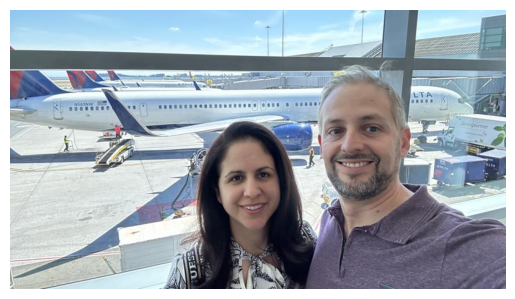

We started our day at the San Francisco International Airport. We were excited to finally
be in San Francisco and ready to explore the city.




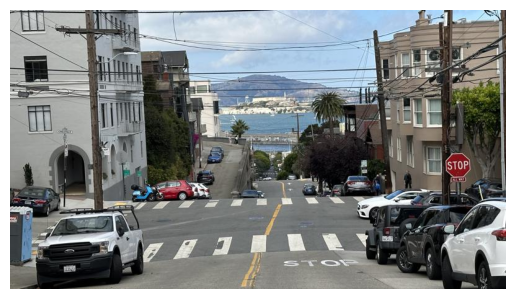

We drove to Russian Hill and found a parking spot. We walked around the neighborhood and
took in the sights and sounds.




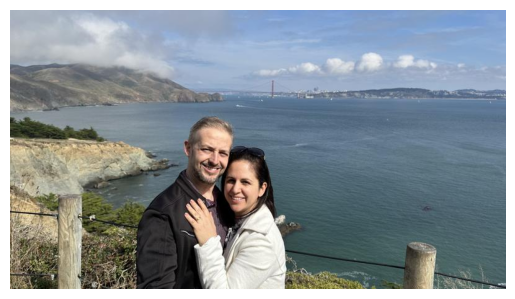

We walked over to the Golden Gate Bridge and took some pictures. It was a beautiful day
and the bridge was stunning.




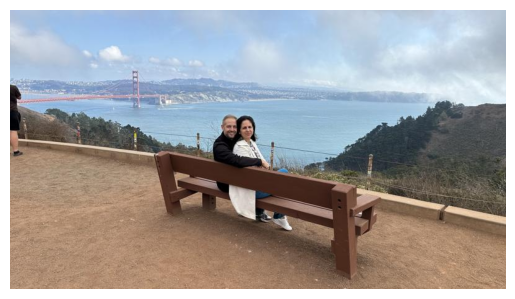

We sat on a bench and watched the boats go by. It was so peaceful and relaxing.




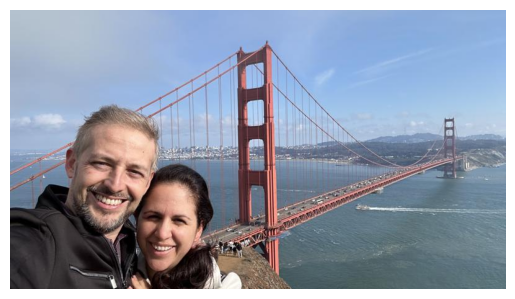

We walked back to our car and drove to the Marina District. We walked around the lake and
enjoyed the scenery.




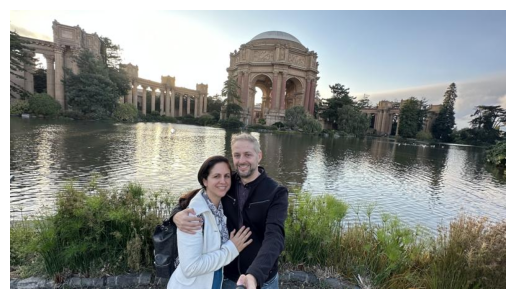

We stopped for dinner at a restaurant in the Marina District. The food was delicious and
the atmosphere was lively.




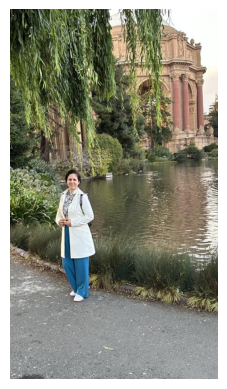

We walked around the Marina District after dinner and took some more pictures. We really
enjoyed our time in this neighborhood.




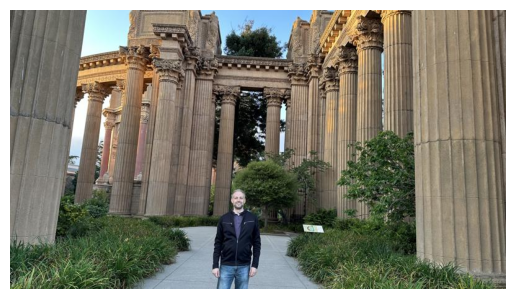

We drove to Fisherman's Wharf and walked around the shops and restaurants. We had some
delicious seafood for dinner.




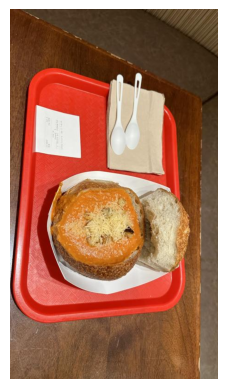

We walked around Fisherman's Wharf after dinner and took some more pictures. We really
enjoyed our time in this neighborhood.




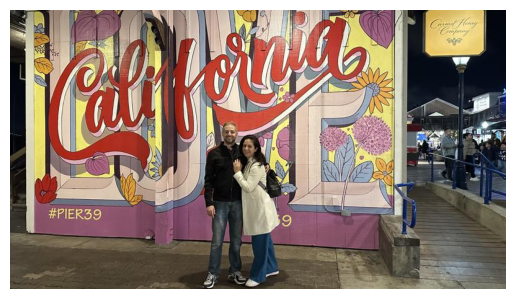

We drove to Fort Mason and walked around the Ghirardelli Square. We had some delicious
chocolate and ice cream.




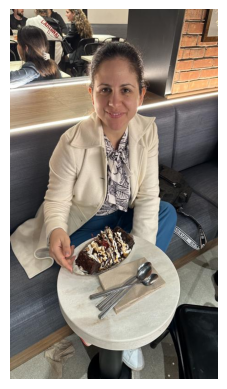

We walked around Fort Mason after dinner and took some more pictures. We really enjoyed
our time in this neighborhood.

We had a wonderful time in San Francisco and we can't wait to come back again soon.


In [ ]:
print_post_with_photos(generated_post_1_sf, images_info_sf)

## Conclusion

This notebook is the result of a funny exercise exploring how we could leverage LLMs and a few APIs to generate a trip blog post from just an album of photos and a sentence with some context about it.

The generated post is not perfect, e.g. sometimes confusing sequence or date/time of events, or mentioning moments typical in the city that we didn't do or register with these photos. But it was still impressive for me how magical can be the user experience when LLMs are combined with useful structured or unstructured data!

My tests sending those generated prompt to [BARD](https://bard.google.com/) and[Chat-GPT](https://chat.openai.com/) sometimes generated even more impressive text about the trips, you might want to give them a try.

What about trying your own photo album with this notebook to see what you get?!